In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'EUR=X'
numbers_in_currency = 'EUR'
share_name = 'TEP.PA'

# 1.1 Calculate Share numbers from total distributed dividend (CFS) and dividend amount

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date', 'real_date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares
0,2014-06-30,1245,0,1245,57,177,515,0,862,681,...,1996,97,8,84,493,17,562,91,-77,57.25
1,2014-12-31,1513,0,1513,95,216,693,0,1110,1019,...,2927,123,2,201,767,424,1332,109,-83,57.25
2,2015-06-30,1658,0,1658,84,261,699,0,1174,1120,...,3101,119,0,240,819,450,1406,190,-88,57.97
3,2015-12-31,1740,0,1740,119,257,754,0,1197,1123,...,3099,117,0,151,745,468,1341,201,-86,57.97
4,2016-06-30,1689,0,1689,87,255,734,0,1196,1097,...,3055,115,5,172,797,416,1336,196,-76,58.31


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
15,2021-12-31,2022-02-11,59.53,3684,0,3684,302,837,1580,0,...,1422,8346,280,2,716,2039,2270,5189,584,-132
16,2022-06-30,2022-07-21,59.71,3946,0,3946,274,756,1642,0,...,1466,8765,242,0,640,2010,2201,5164,616,-151
17,2022-12-31,2023-02-11,59.71,4208,0,4208,371,817,1707,0,...,1345,8864,232,4,884,2288,2021,5192,678,-147
18,2023-06-30,2023-07-21,59.10,3960,0,3960,271,727,1715,0,...,1256,8769,216,2,949,2271,1878,5049,590,-112
19,2023-12-31,2024-02-11,59.10,4385,0,4385,331,882,2132,0,...,1297,11754,334,15,1,2708,3822,7522,785,-121


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
15,2021-12-31,2022-02-11,59.53,3684,0,3684,302,837,1580,0,...,8346,280,2,716,2039,2270,5189,584,-132,0.874514
16,2022-06-30,2022-07-21,59.71,3946,0,3946,274,756,1642,0,...,8765,242,0,640,2010,2201,5164,616,-151,0.938325
17,2022-12-31,2023-02-11,59.71,4208,0,4208,371,817,1707,0,...,8864,232,4,884,2288,2021,5192,678,-147,0.980663
18,2023-06-30,2023-07-21,59.10,3960,0,3960,271,727,1715,0,...,8769,216,2,949,2271,1878,5049,590,-112,0.918362
19,2023-12-31,2024-02-11,59.10,4385,0,4385,331,882,2132,0,...,11754,334,15,1,2708,3822,7522,785,-121,0.929674


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
15,2021-12-31,2022-02-11,59.53,3684,0,3684,302,837,1580,0,...,8346,280,2,716,2039,2270,5189,584,-132,0.874514
16,2022-06-30,2022-07-21,59.71,3946,0,3946,274,756,1642,0,...,8765,242,0,640,2010,2201,5164,616,-151,0.938325
17,2022-12-31,2023-02-11,59.71,4208,0,4208,371,817,1707,0,...,8864,232,4,884,2288,2021,5192,678,-147,0.980663
18,2023-06-30,2023-07-21,59.10,3960,0,3960,271,727,1715,0,...,8769,216,2,949,2271,1878,5049,590,-112,0.918362
19,2023-12-31,2024-02-11,59.10,4385,0,4385,331,882,2132,0,...,11754,334,15,1,2708,3822,7522,785,-121,0.929674


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

## Calculate performance parameters (current ratio, ROA, ROE, margins, D/E)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2014-07-21,43.451965,2014-06-30,1245.0,3.982533,25.048035,57.25,672.0,11.737991,177.0,...,0.718437,0.281563,9.669903,0.0,28.135593,0.0,1.0,0.045783,0.114228,0.158996
1,2014-07-28,44.951225,2014-06-30,1245.0,3.982533,25.048035,57.25,672.0,11.737991,177.0,...,0.718437,0.281563,9.669903,0.0,28.135593,0.0,1.0,0.045783,0.114228,0.158996
2,2014-08-04,43.920490,2014-06-30,1245.0,3.982533,25.048035,57.25,672.0,11.737991,177.0,...,0.718437,0.281563,9.669903,0.0,28.135593,0.0,1.0,0.045783,0.114228,0.158996
3,2014-08-11,43.862484,2014-06-30,1245.0,3.982533,25.048035,57.25,672.0,11.737991,177.0,...,0.718437,0.281563,9.669903,0.0,28.135593,0.0,1.0,0.045783,0.114228,0.158996
4,2014-08-18,44.032040,2014-06-30,1245.0,3.982533,25.048035,57.25,672.0,11.737991,177.0,...,0.718437,0.281563,9.669903,0.0,28.135593,0.0,1.0,0.045783,0.114228,0.158996


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2014-07-21,43.451965,2014-06-30,1245.0,3.982533,25.048035,57.25,672.0,11.737991,177.0,...,0.0,1.0,0.045783,0.114228,0.158996,10.910636,1.734745,0.499523,0.576832,3.701823
1,2014-07-28,44.951225,2014-06-30,1245.0,3.982533,25.048035,57.25,672.0,11.737991,177.0,...,0.0,1.0,0.045783,0.114228,0.158996,11.287095,1.794601,0.516759,0.594068,3.829550
2,2014-08-04,43.920490,2014-06-30,1245.0,3.982533,25.048035,57.25,672.0,11.737991,177.0,...,0.0,1.0,0.045783,0.114228,0.158996,11.028281,1.753451,0.504909,0.582218,3.741738
3,2014-08-11,43.862484,2014-06-30,1245.0,3.982533,25.048035,57.25,672.0,11.737991,177.0,...,0.0,1.0,0.045783,0.114228,0.158996,11.013716,1.751135,0.504242,0.581552,3.736796
4,2014-08-18,44.032040,2014-06-30,1245.0,3.982533,25.048035,57.25,672.0,11.737991,177.0,...,0.0,1.0,0.045783,0.114228,0.158996,11.056291,1.757904,0.506192,0.583501,3.751241


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

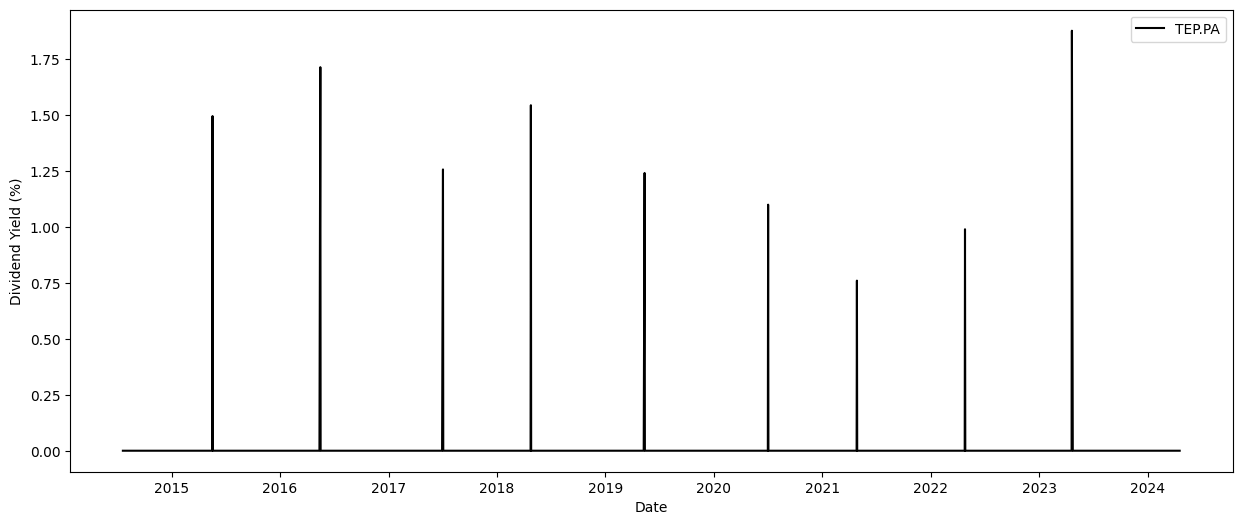

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate    0.078218
share_price      1.000000
Name: share_price, dtype: float64


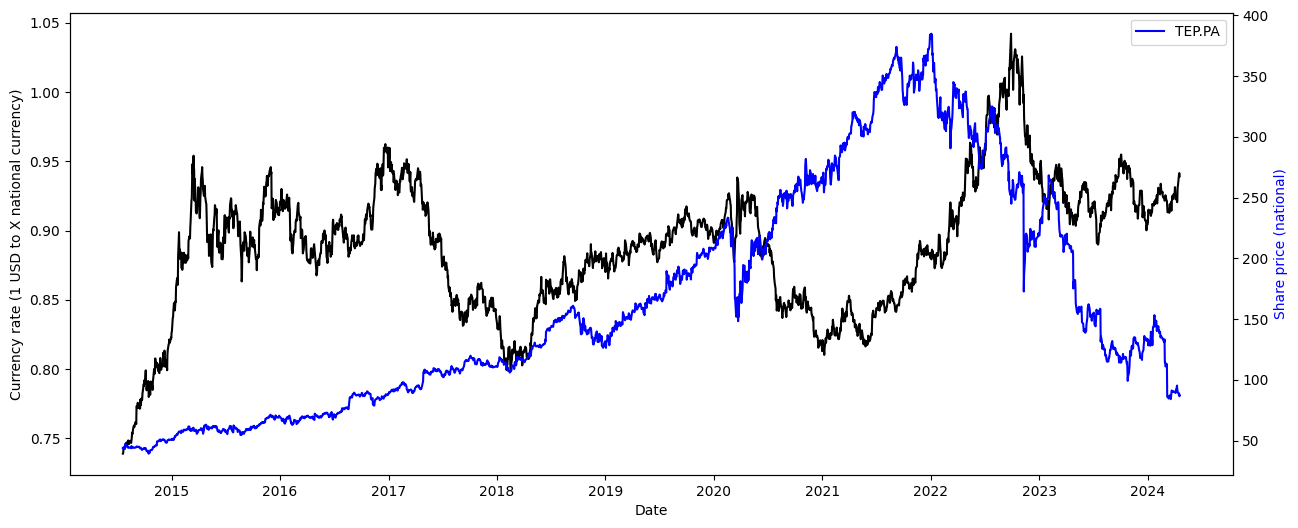

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

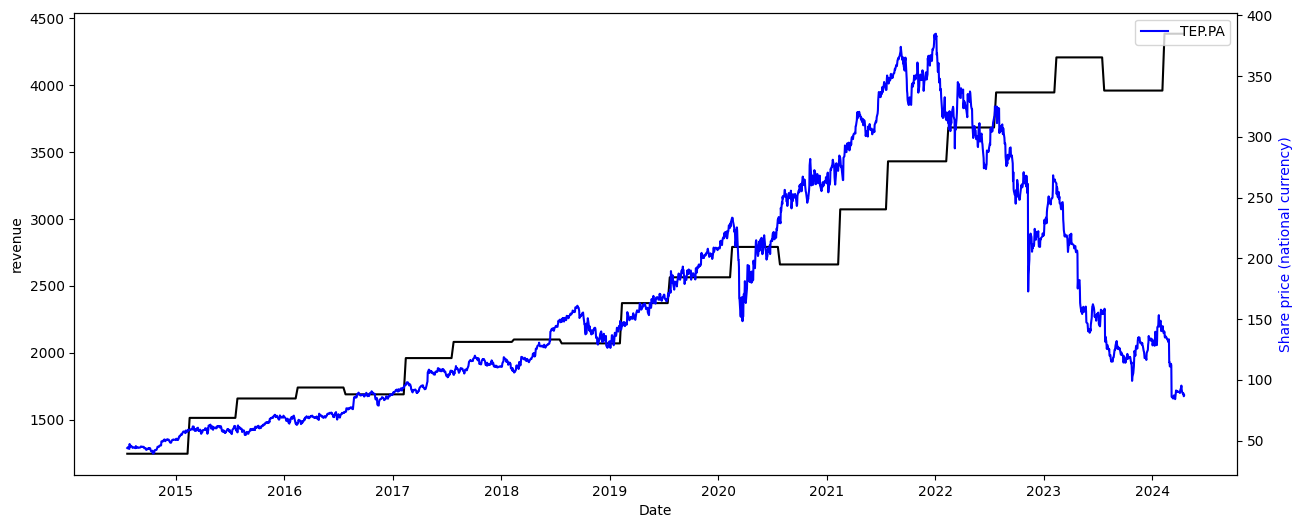

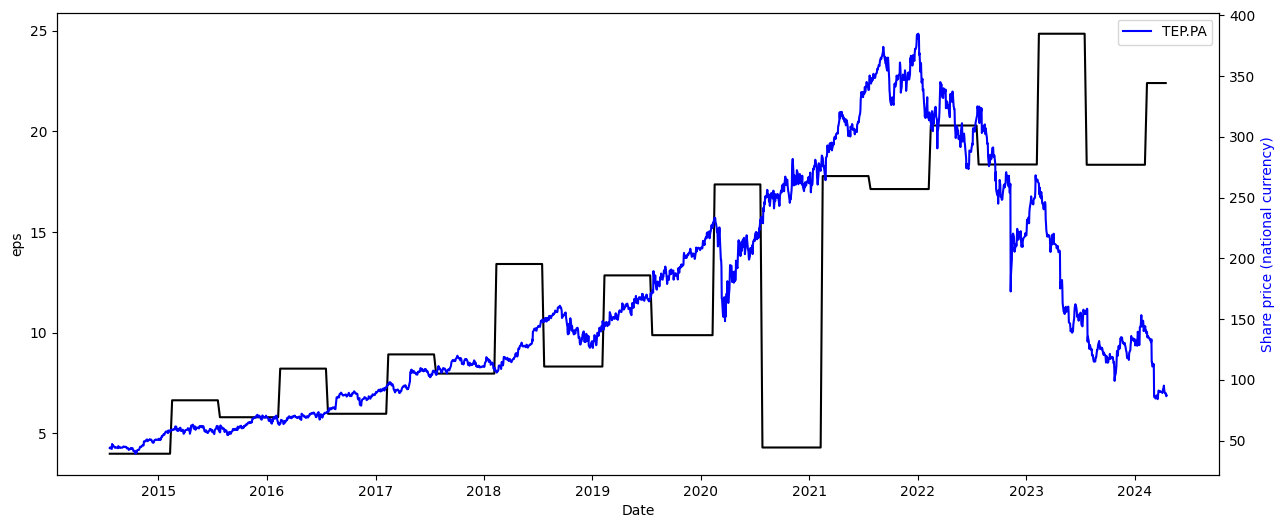

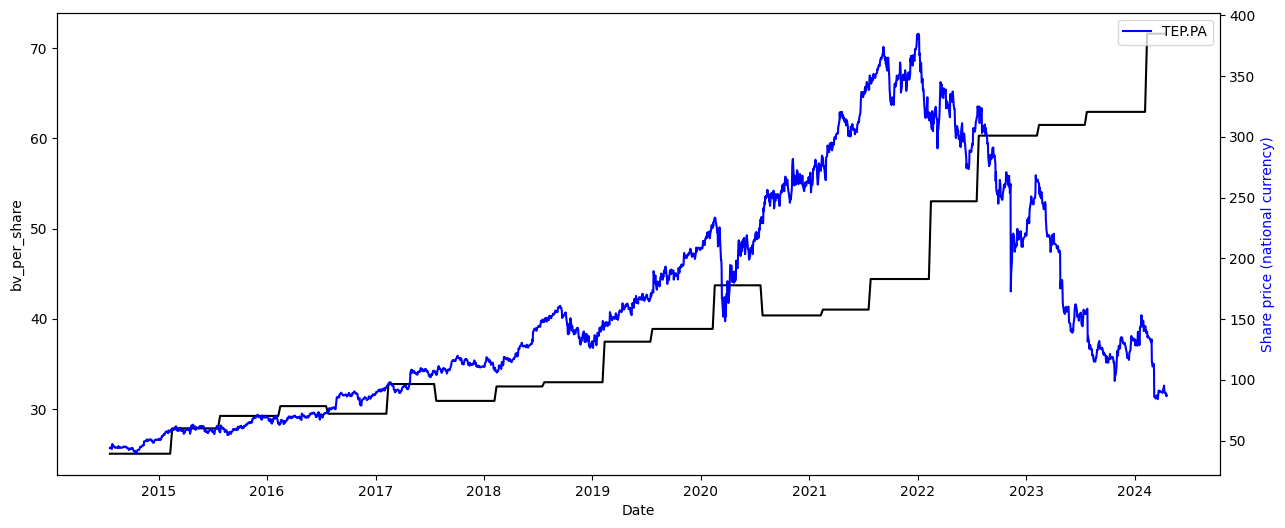

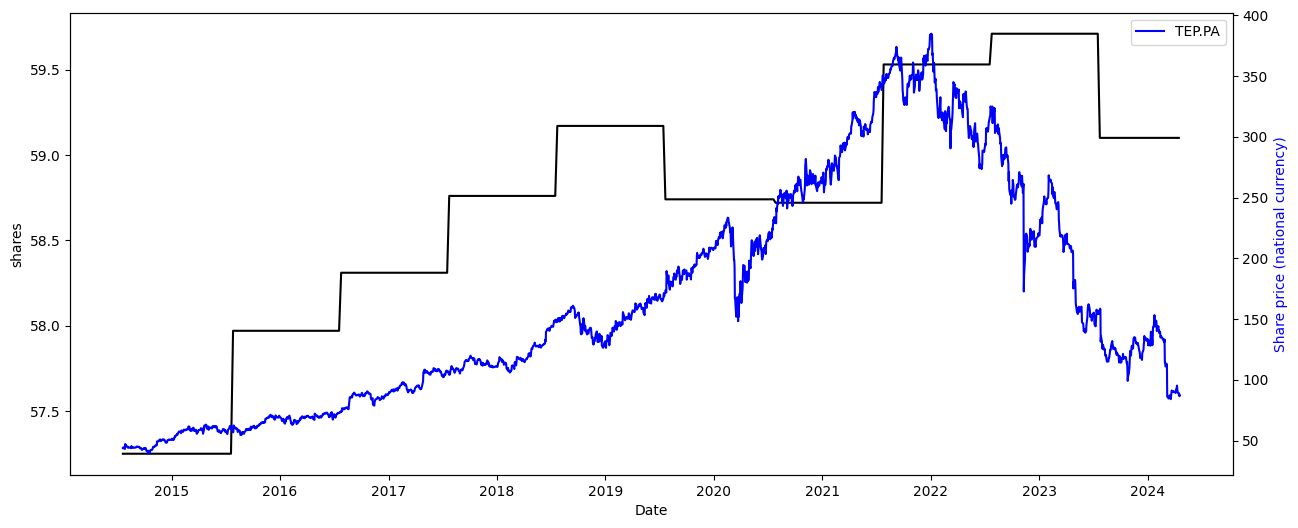

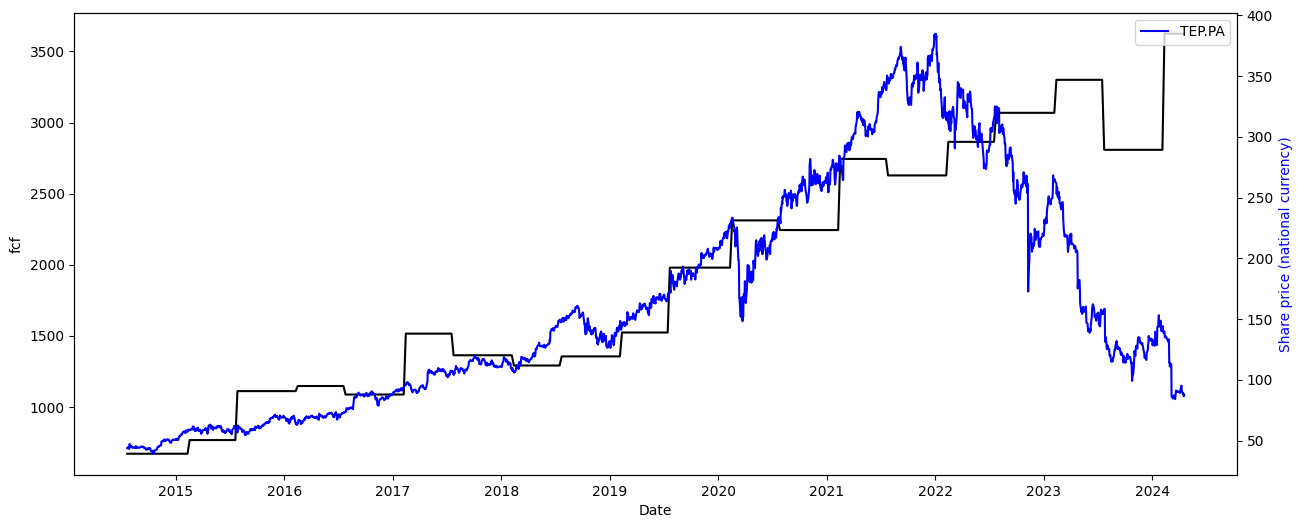

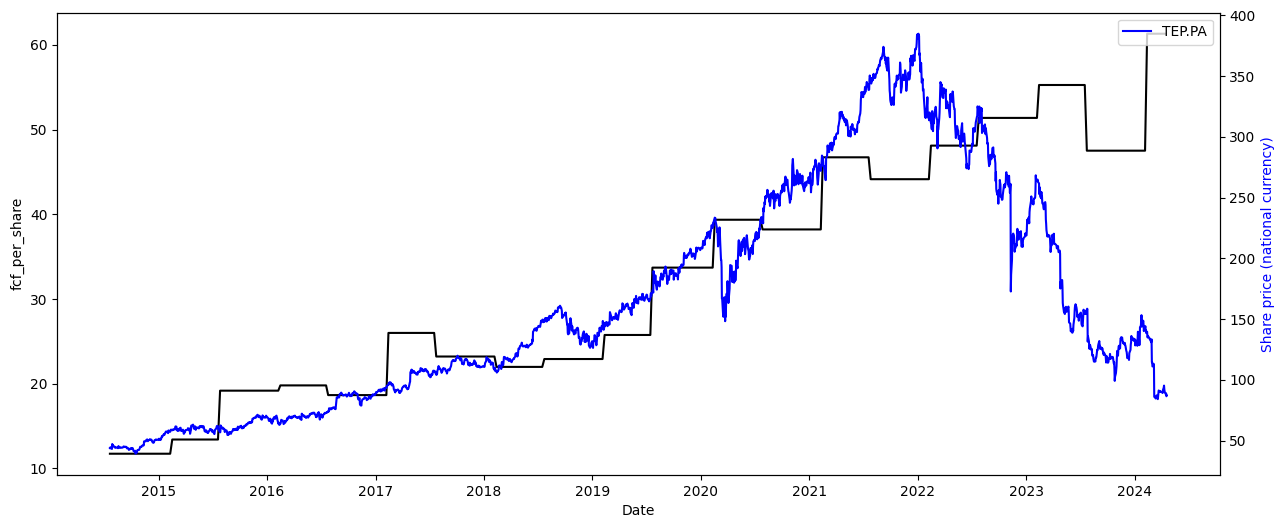

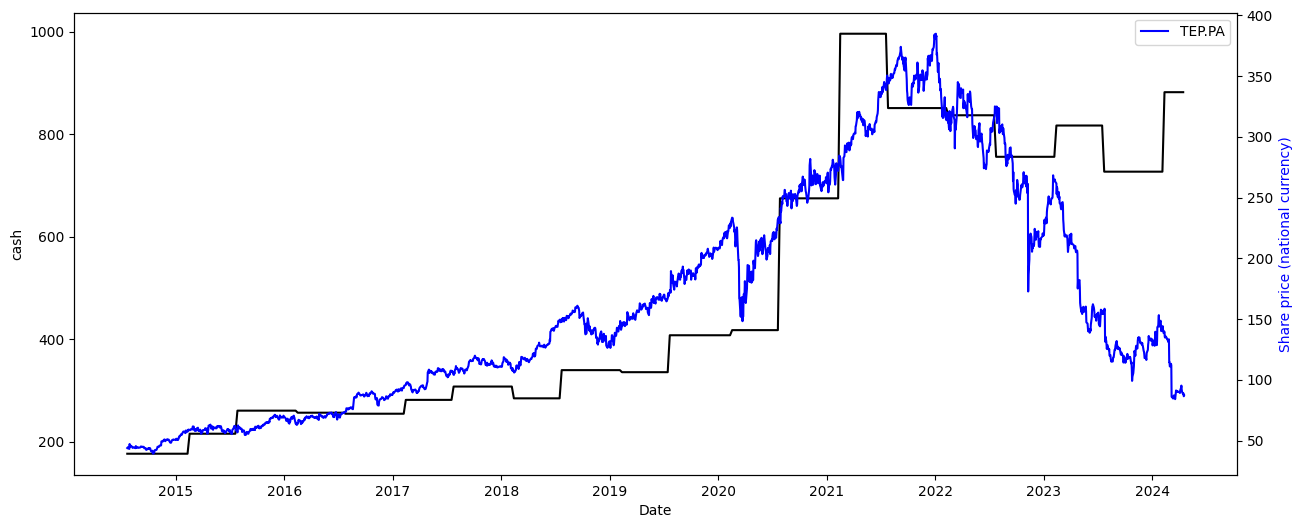

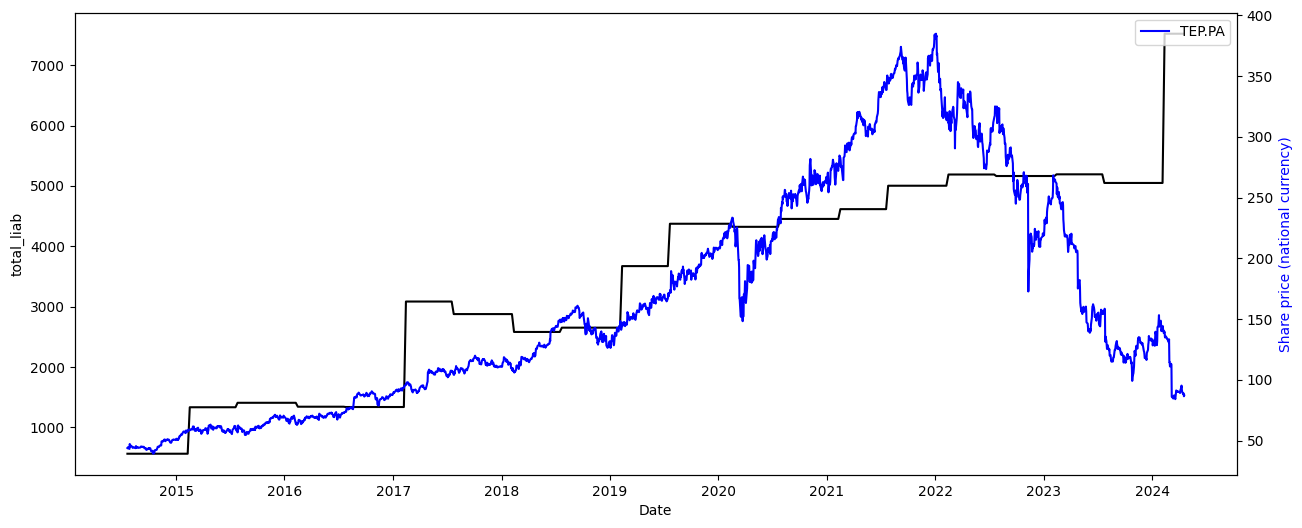

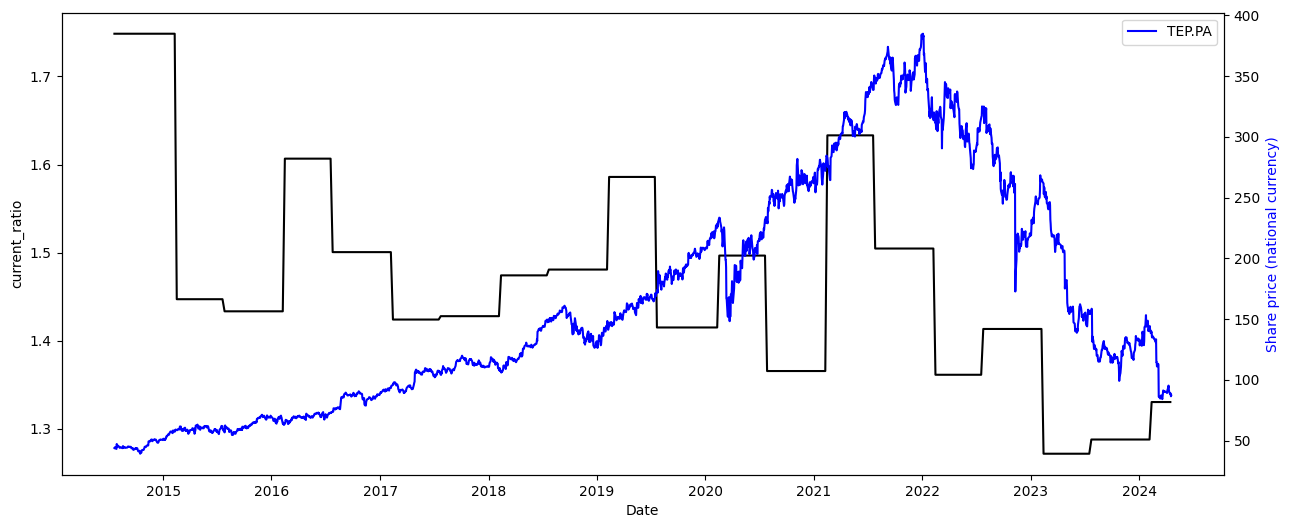

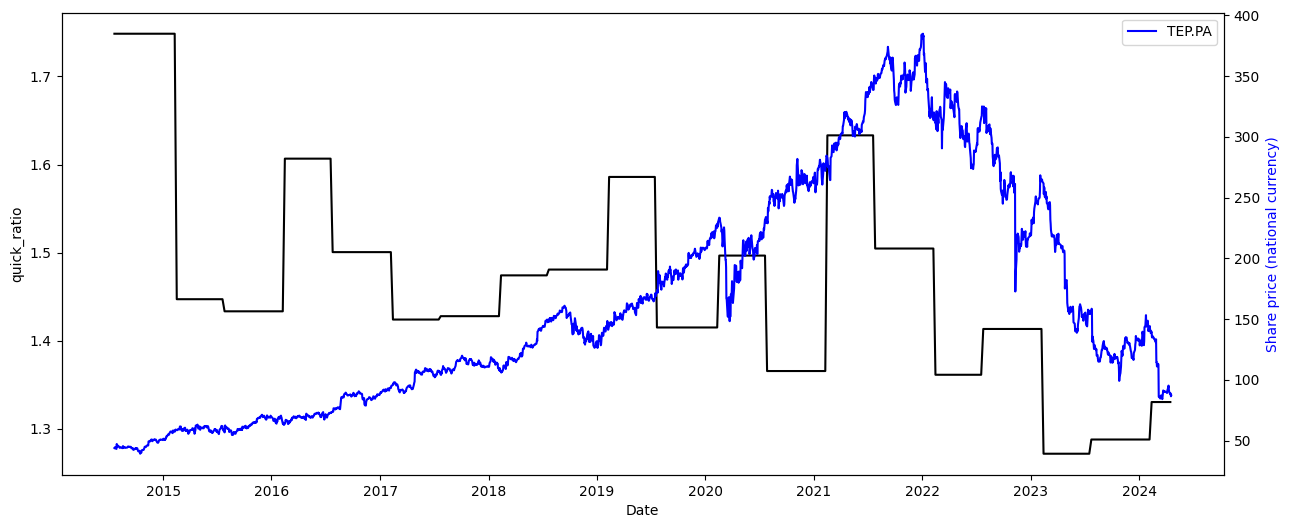

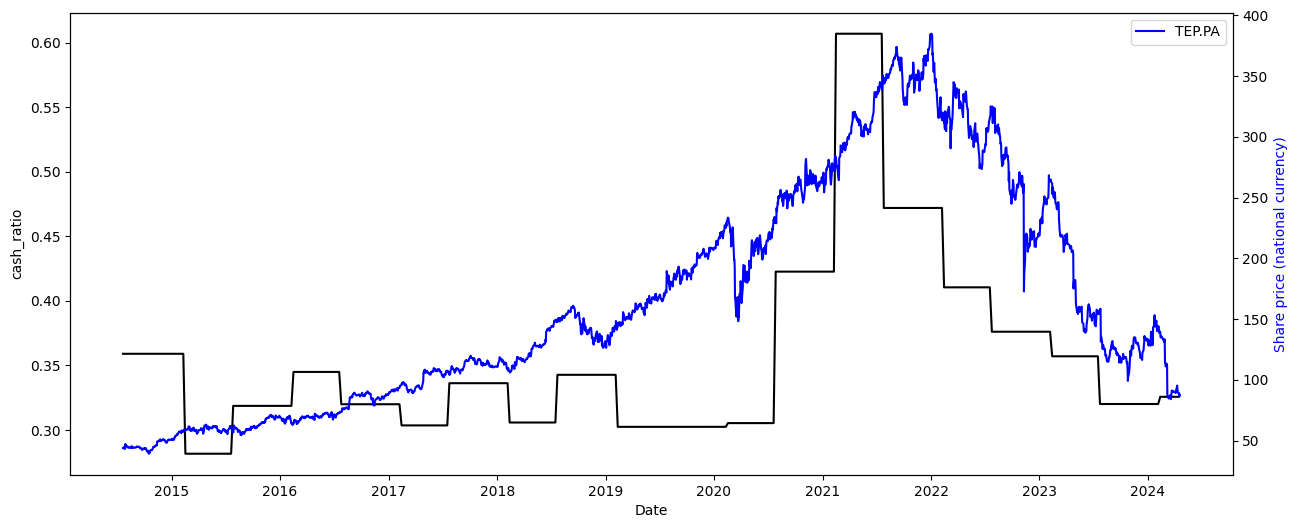

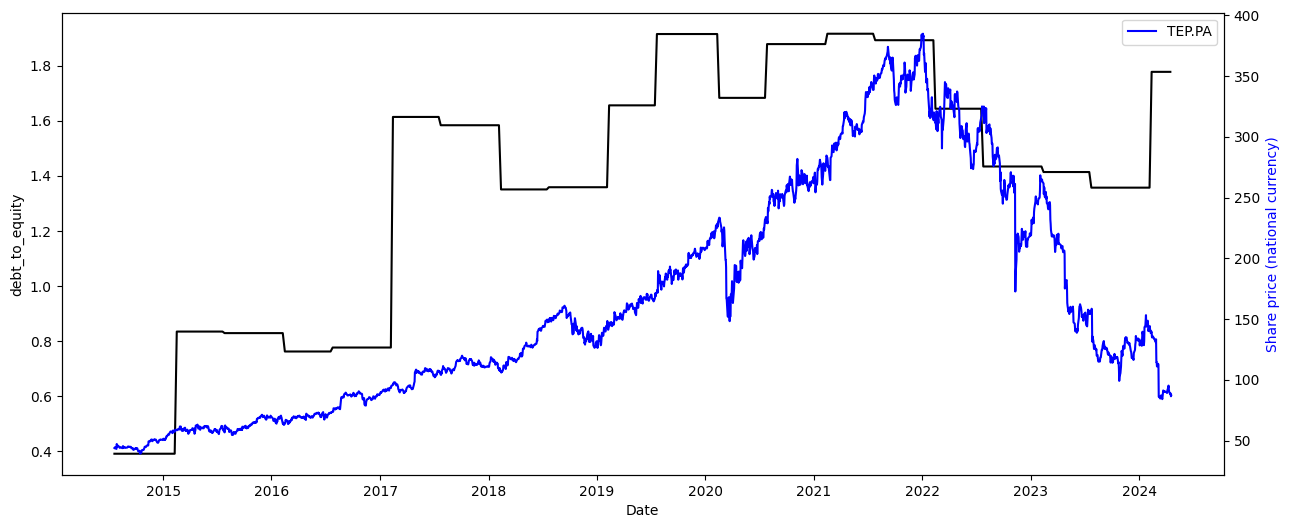

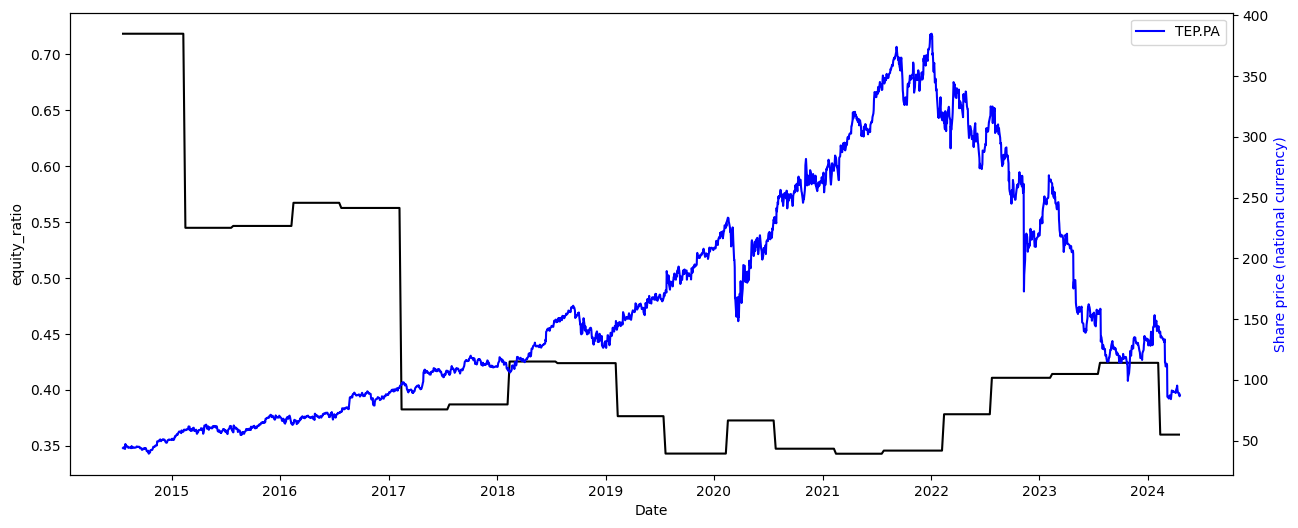

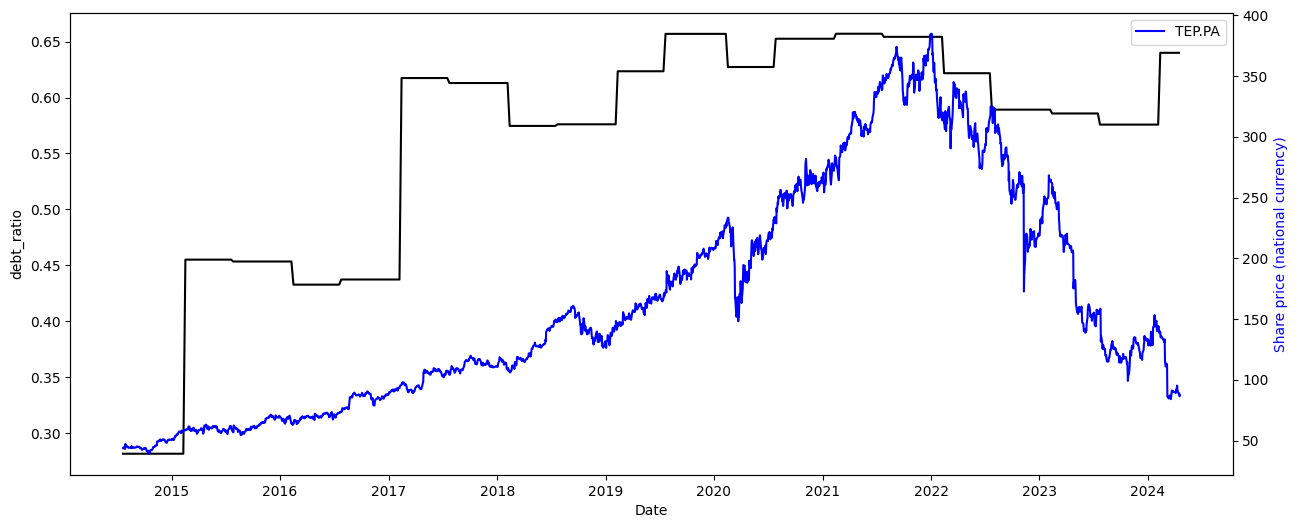

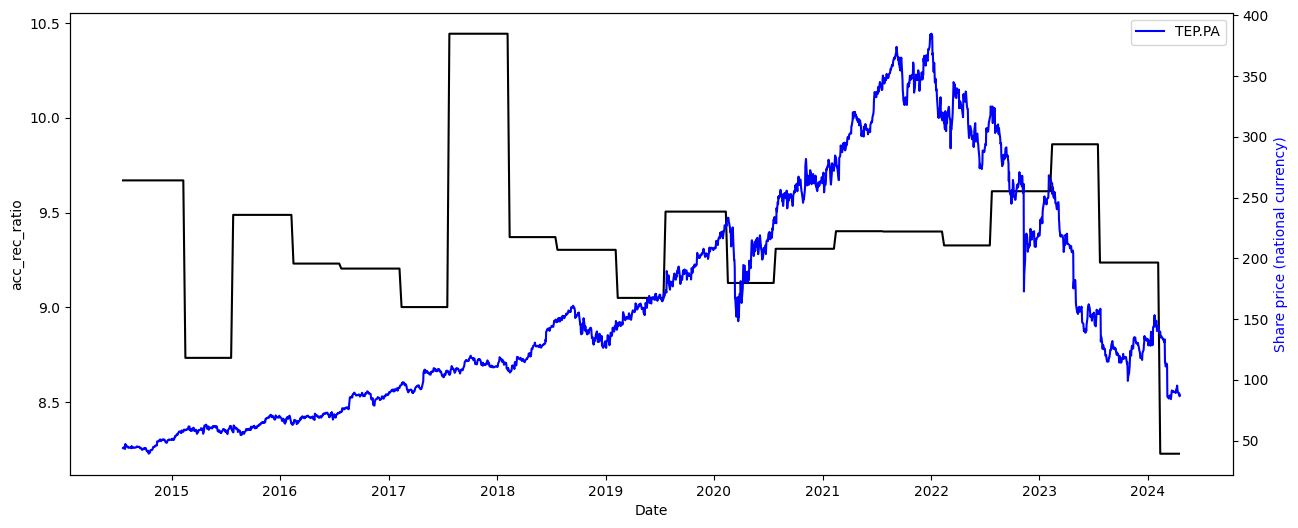

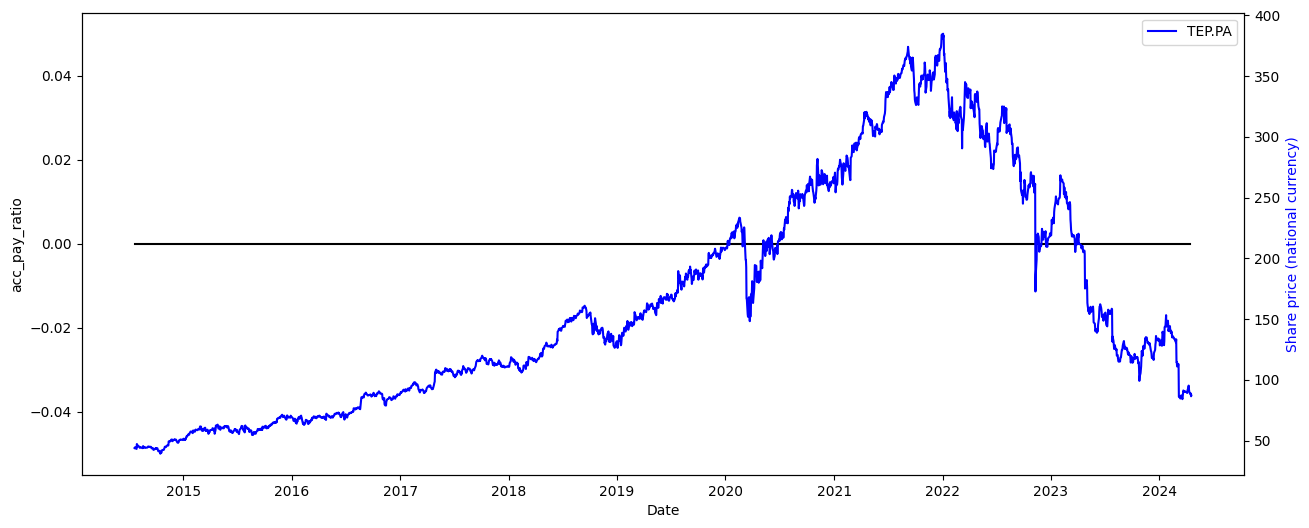

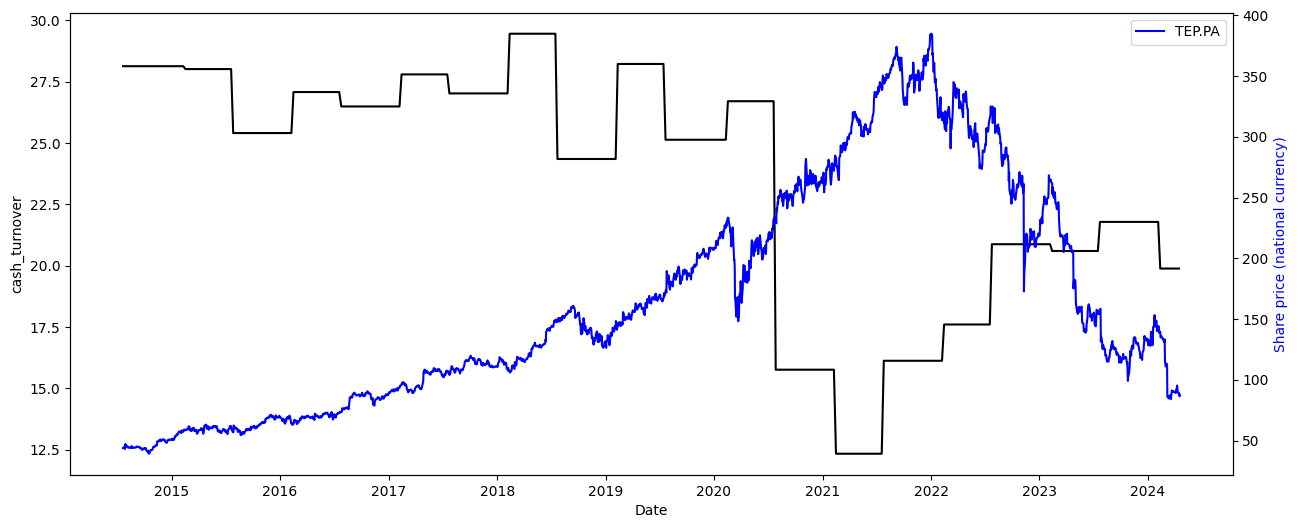

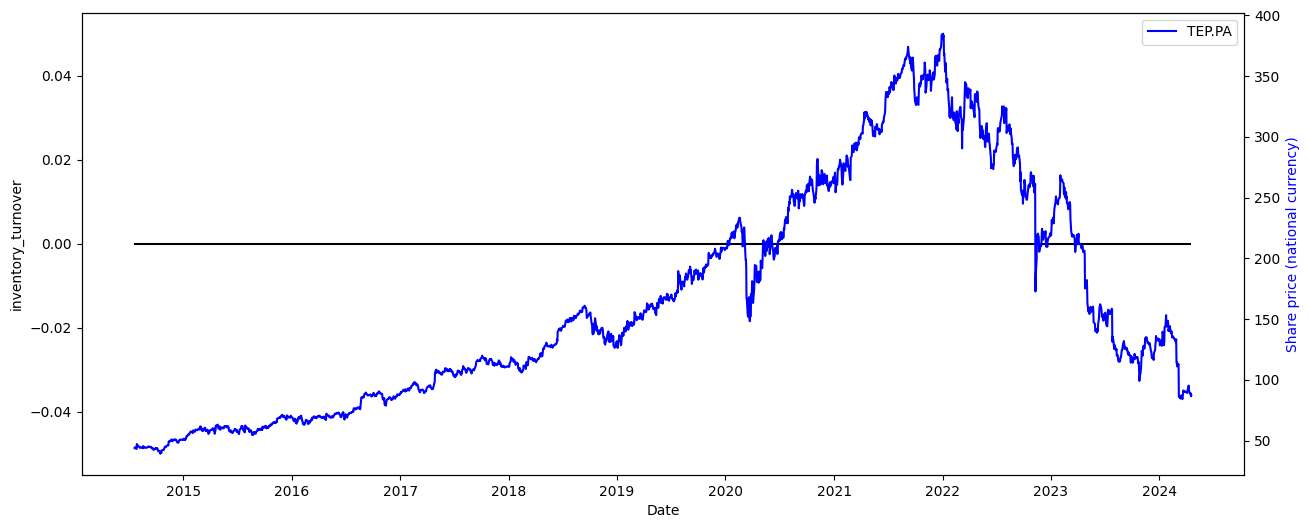

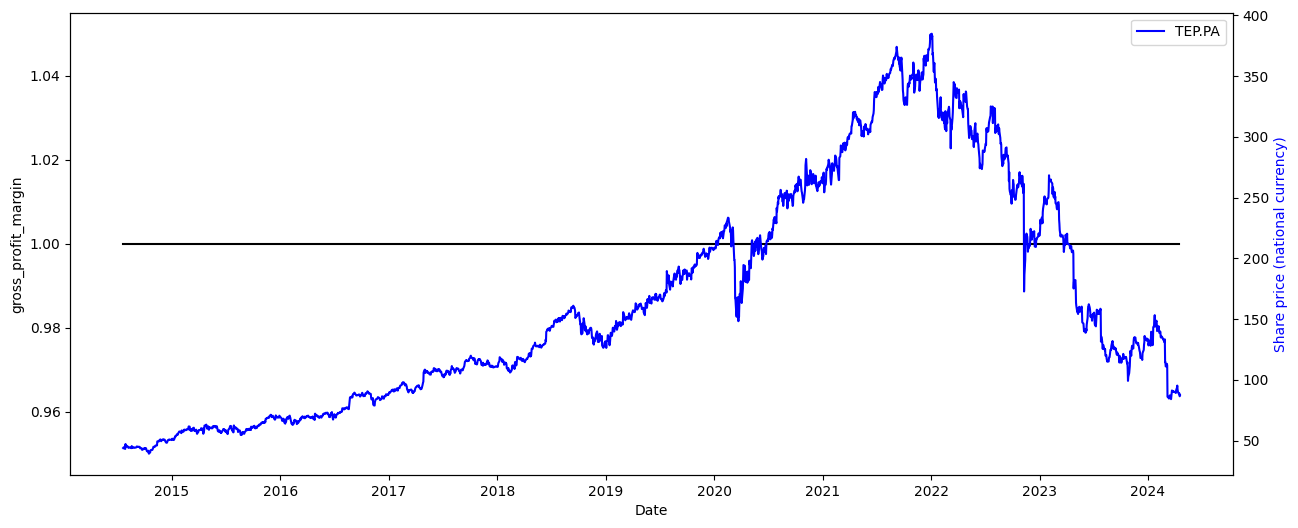

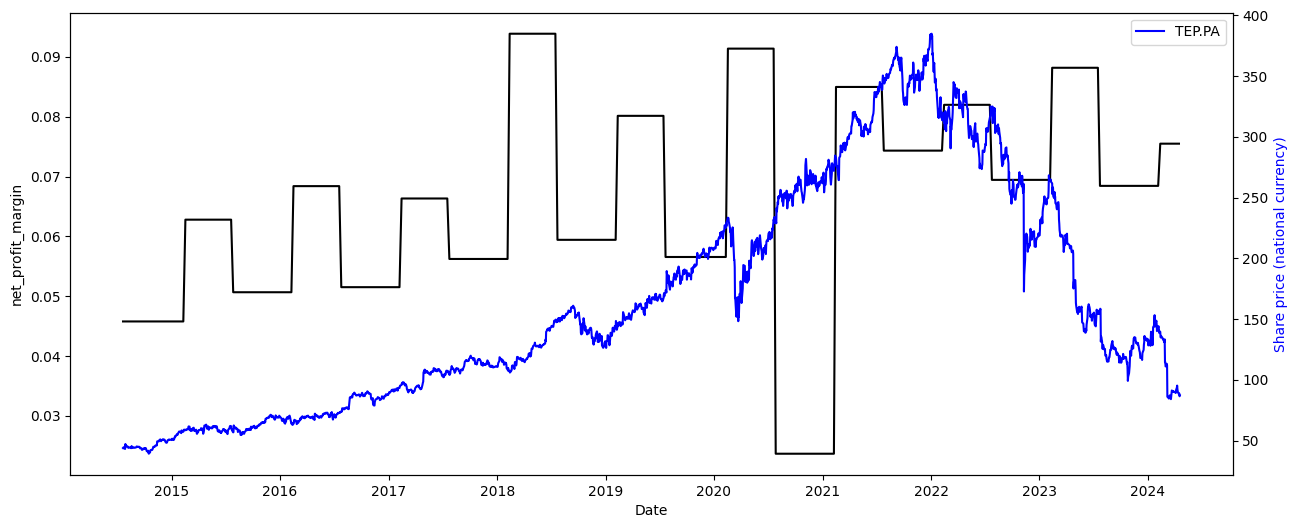

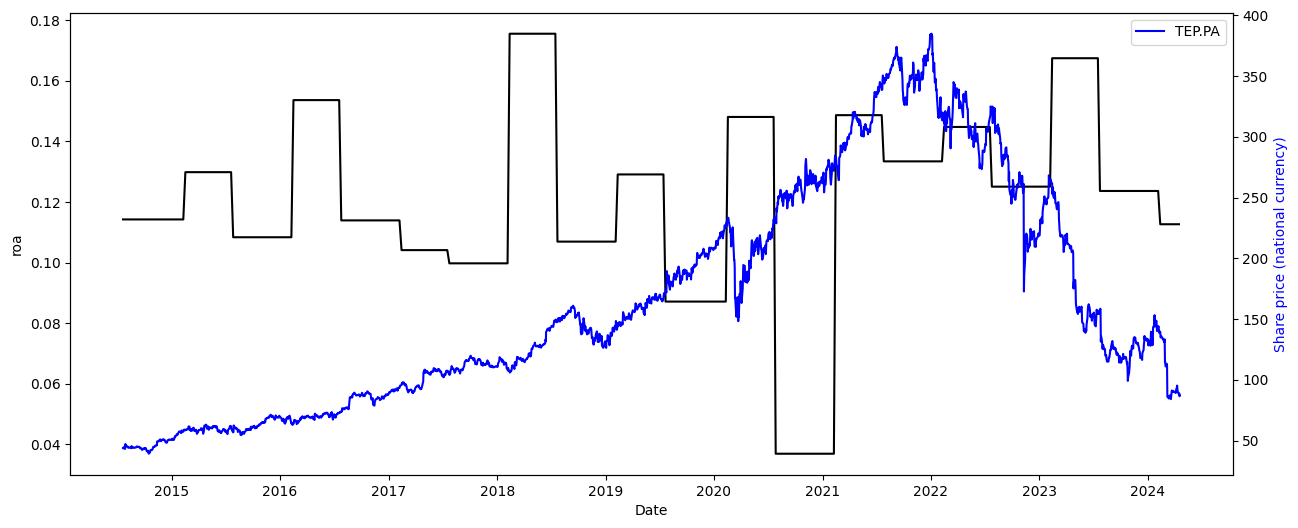

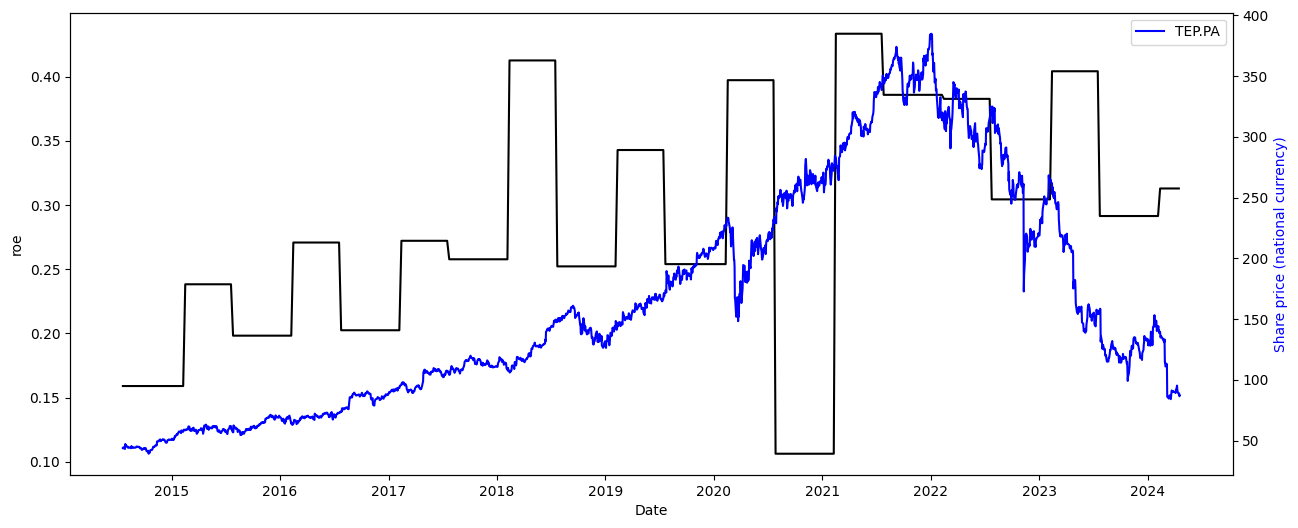

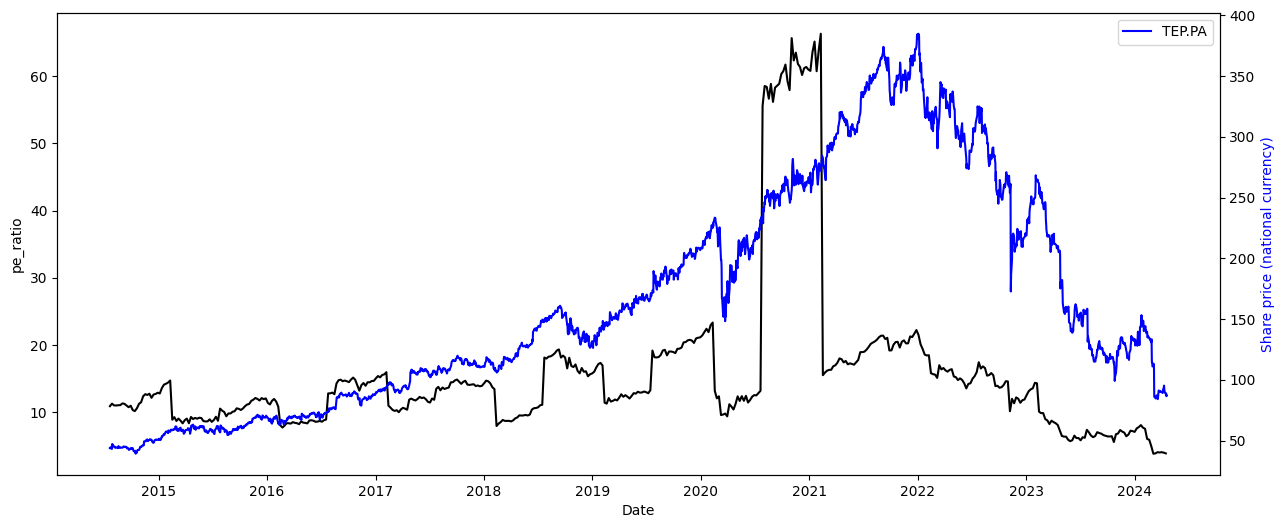

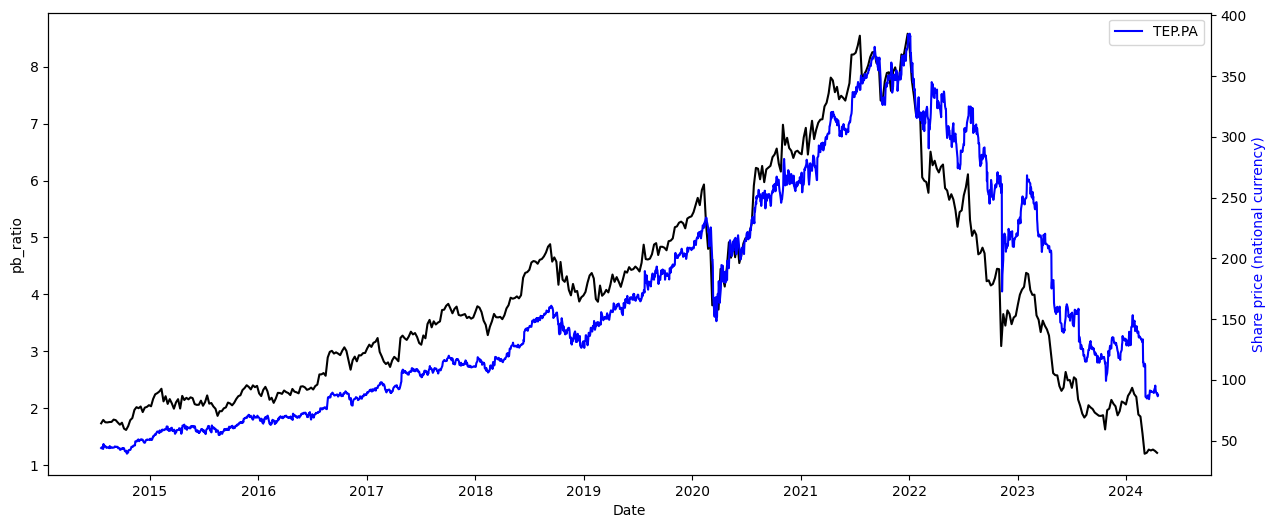

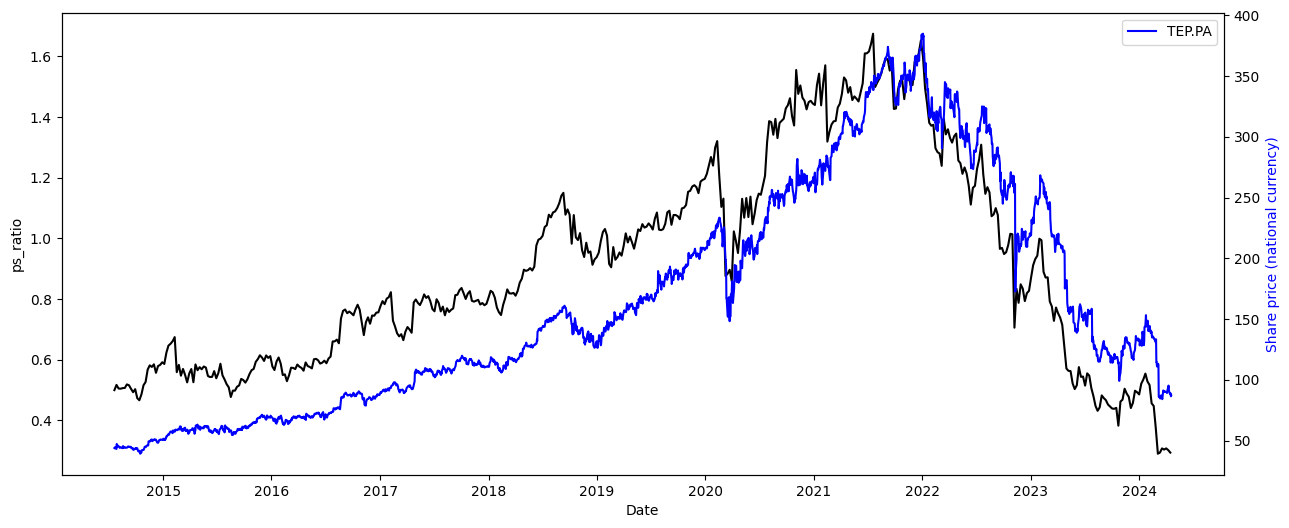

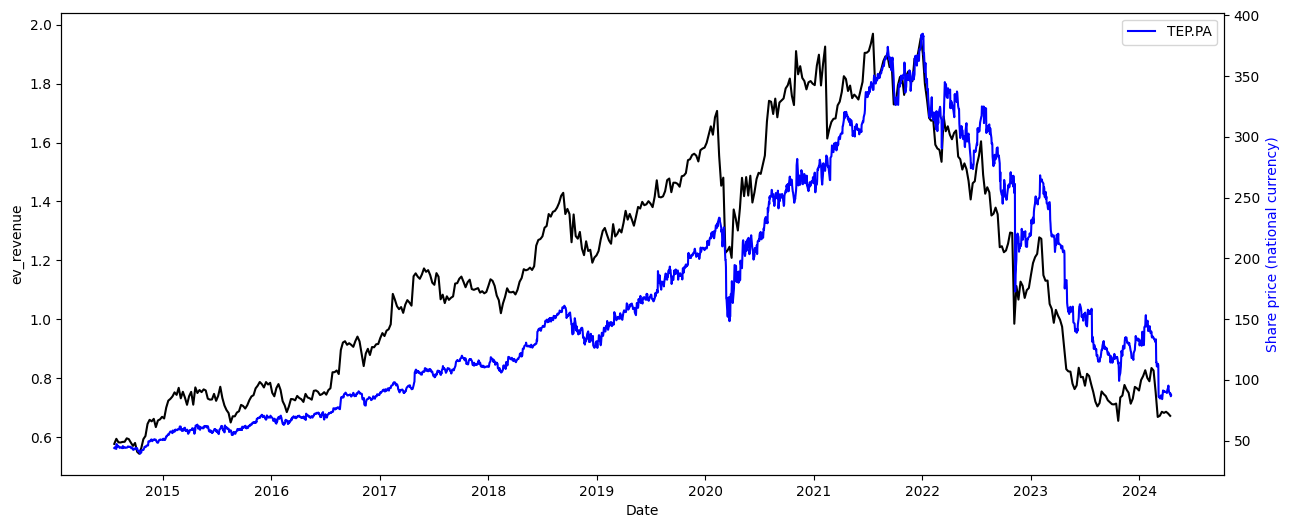

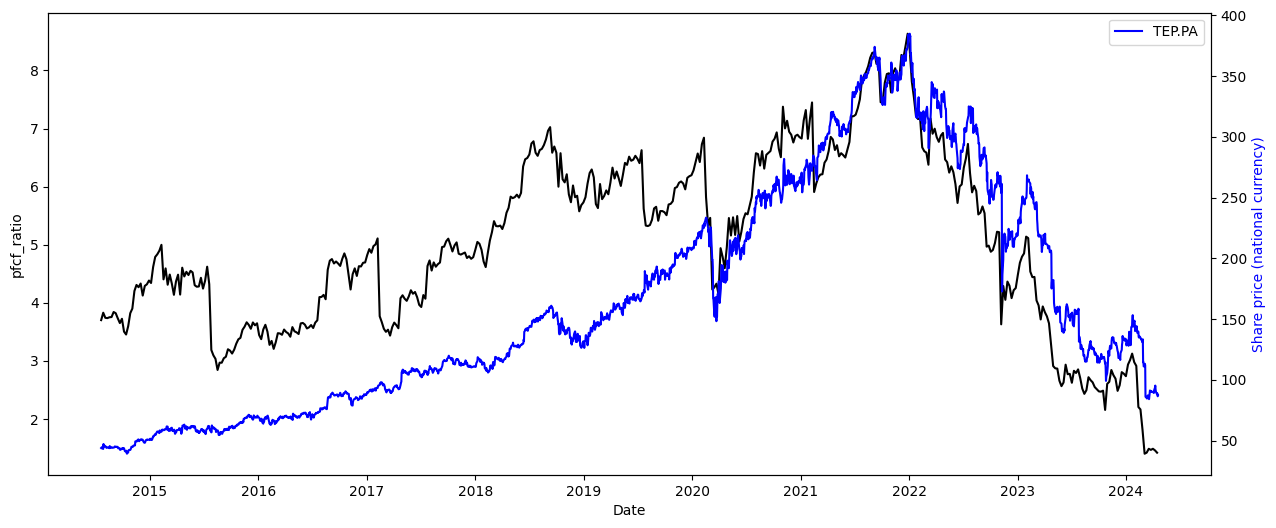

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

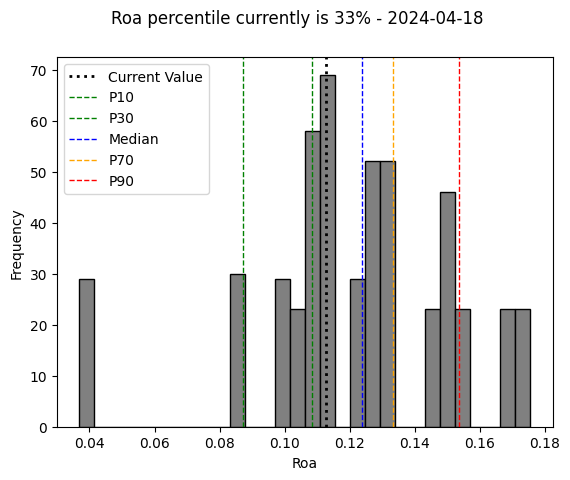

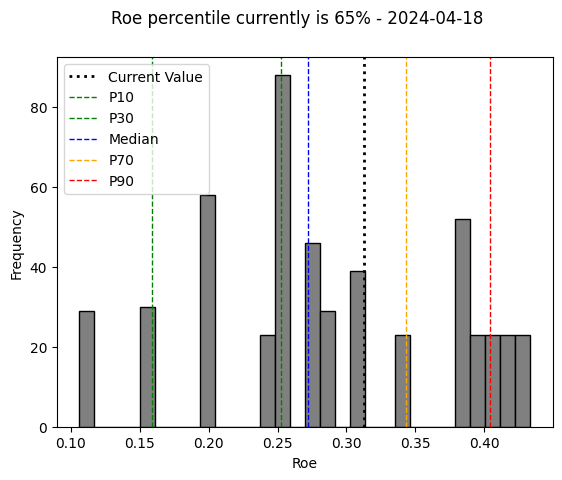

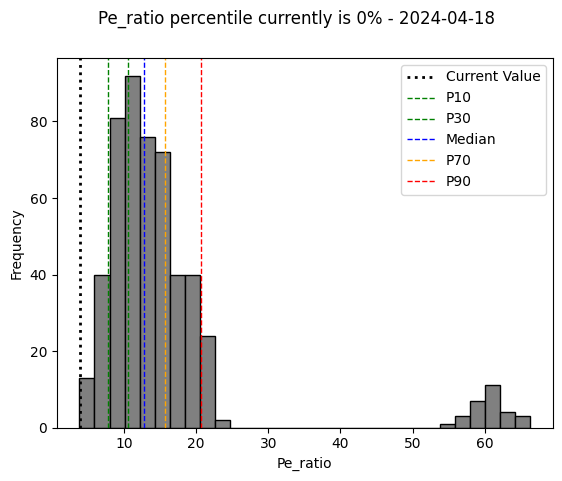

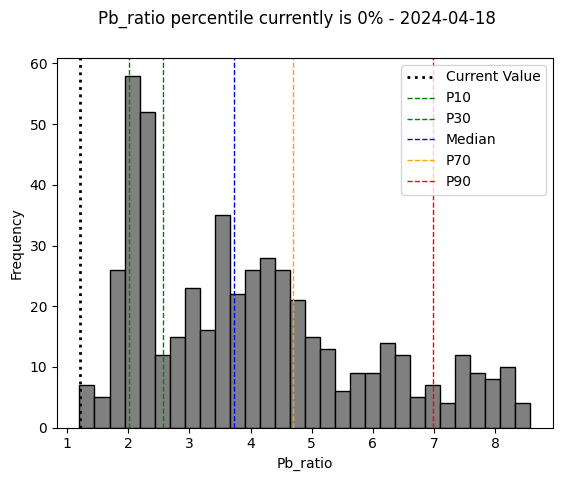

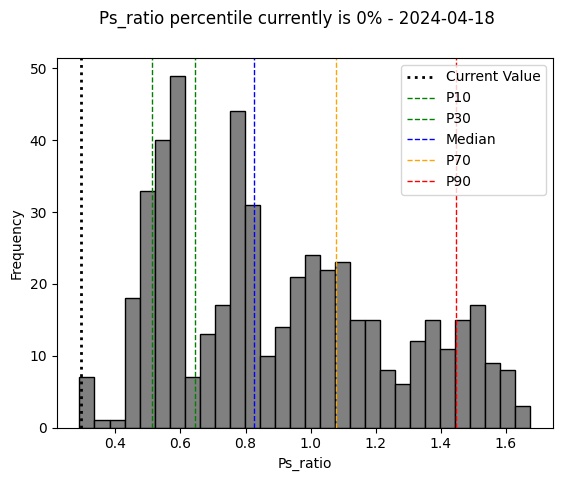

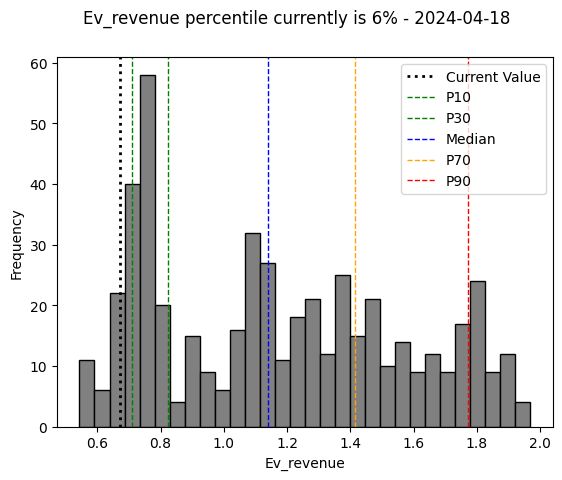

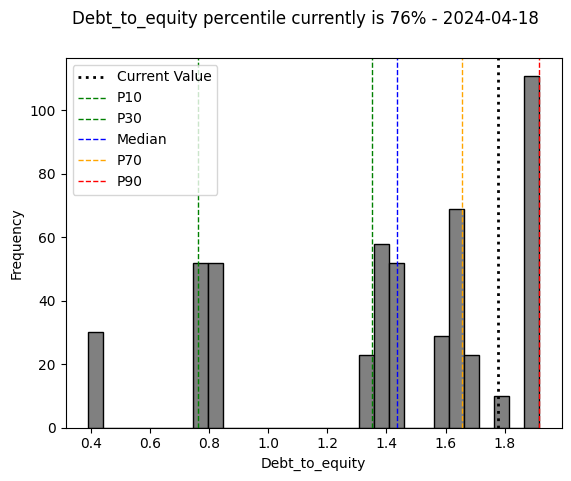

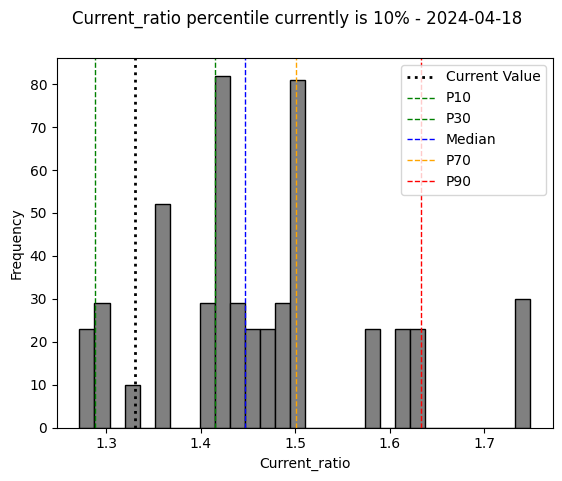

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.801096,-0.726965,-0.103833,-0.170457,-0.197834,-0.162100,0.156466
roe,0.801096,1.000000,-0.446018,0.356451,0.275643,0.313629,0.451073,-0.079908
pe_ratio,-0.726965,-0.446018,1.000000,0.568552,0.628697,0.617387,0.396003,-0.115060
pb_ratio,-0.103833,0.356451,0.568552,1.000000,0.988386,0.974501,0.738946,0.031220
ps_ratio,-0.170457,0.275643,0.628697,0.988386,1.000000,0.983907,0.708748,0.055187
ev_revenue,-0.197834,0.313629,0.617387,0.974501,0.983907,1.000000,0.817191,-0.052572
debt_to_equity,-0.162100,0.451073,0.396003,0.738946,0.708748,0.817191,1.000000,-0.402199
current_ratio,0.156466,-0.079908,-0.115060,0.031220,0.055187,-0.052572,-0.402199,1.000000


10 timestemos have been found!


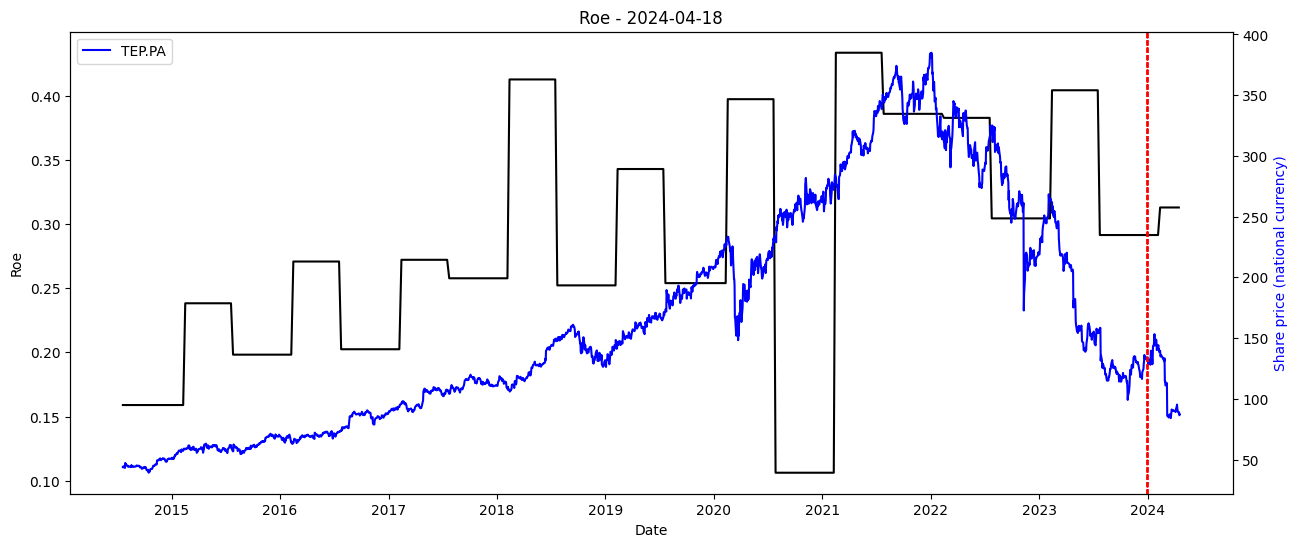

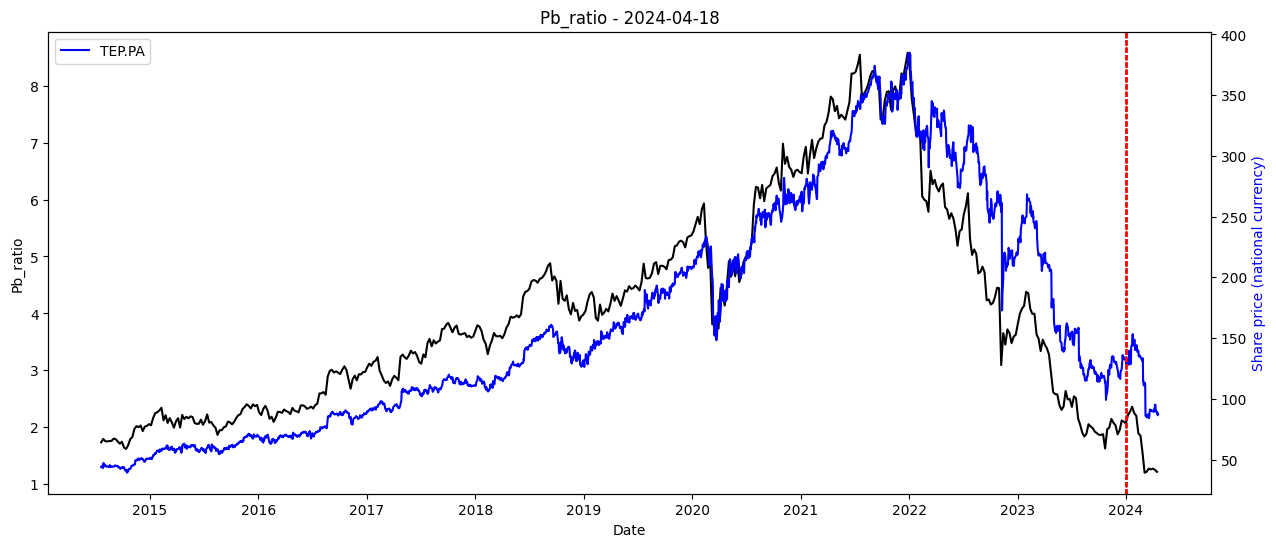

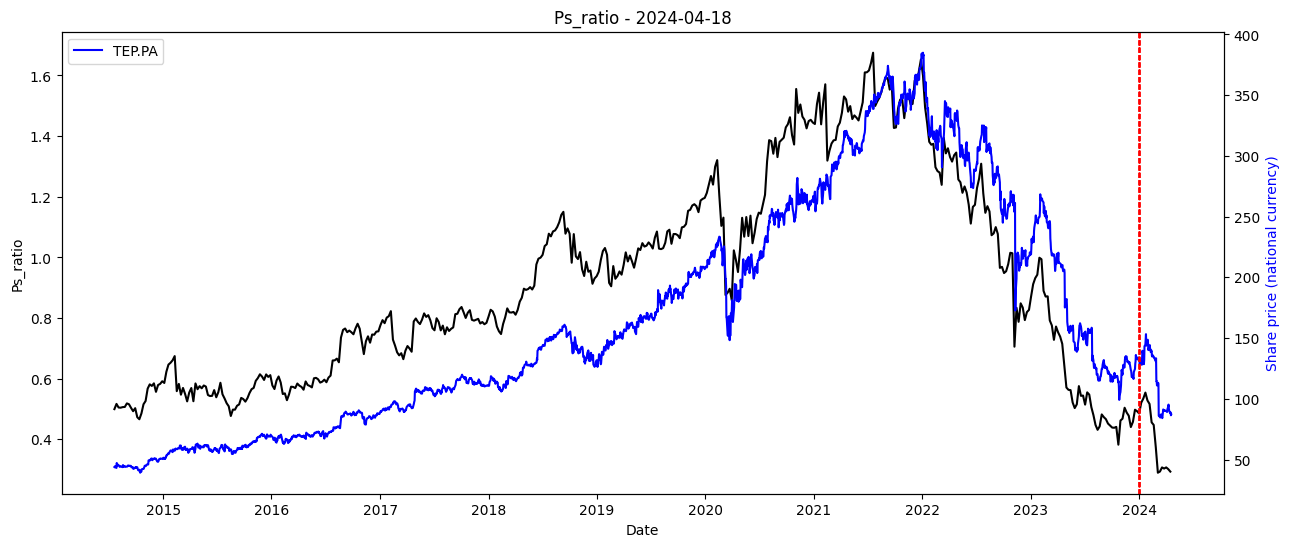

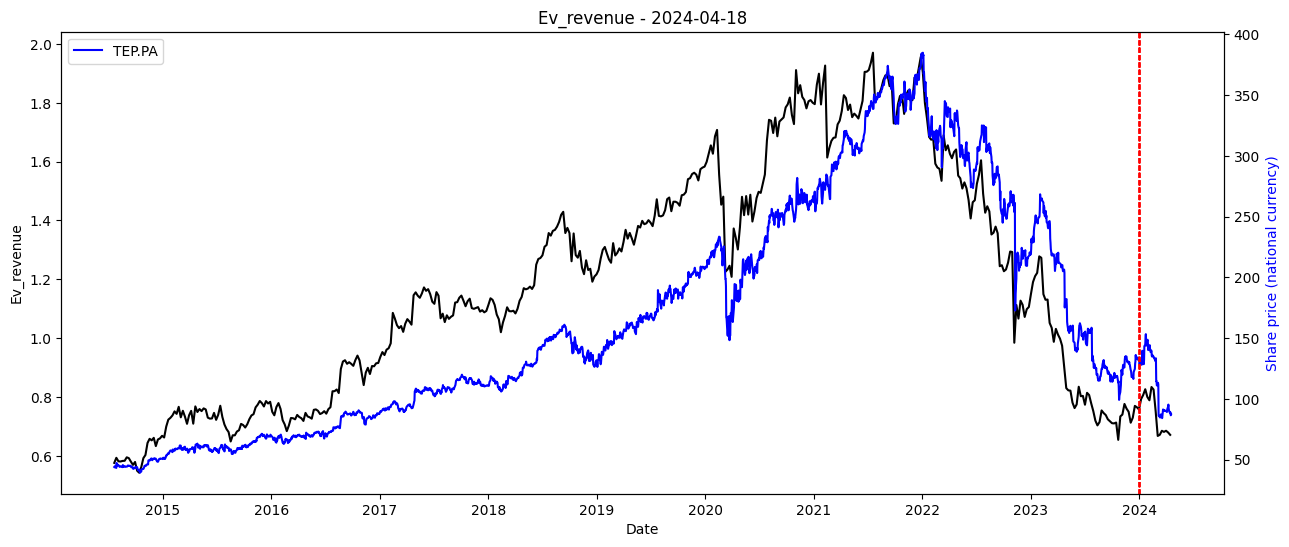

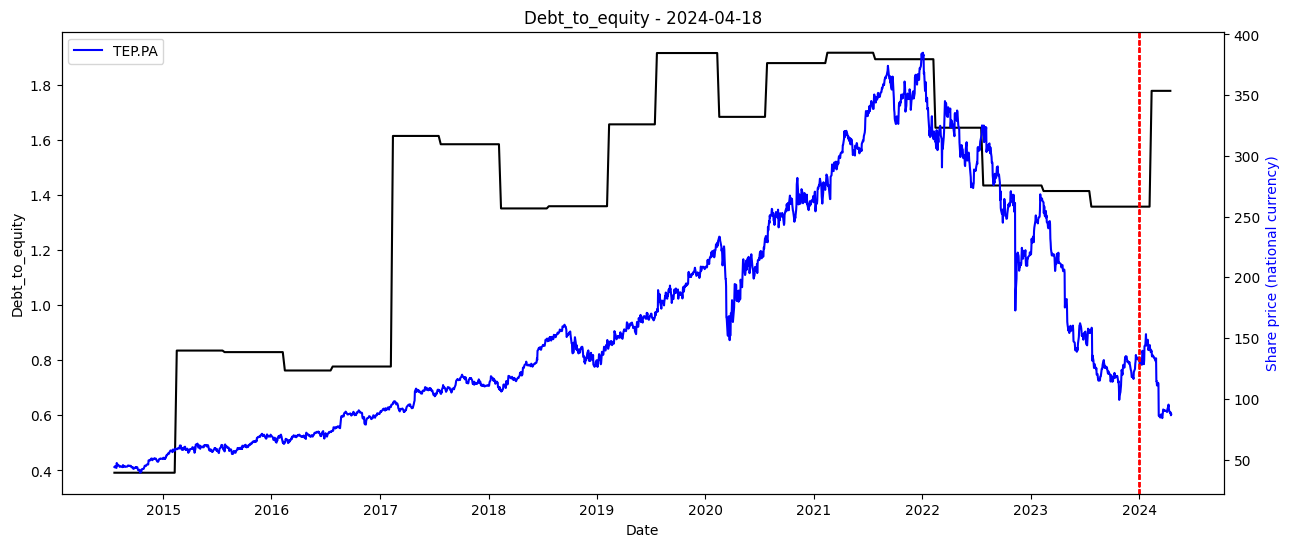

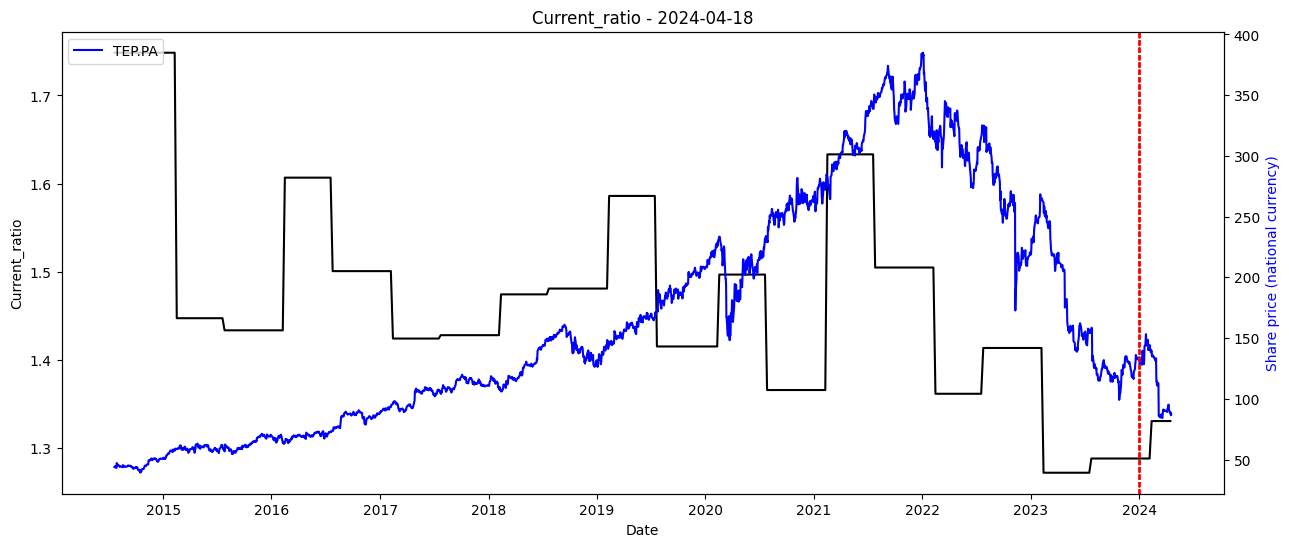

In [21]:
# plot value parameters in time and identify similar events
utils.get_historical_analouges(
    input_df=merged_nat_curr,
    ticker_all_price=ticker_all_price,
    share_name=share_name,
    tolerance=0.2,
    owned_shares=owned_shares
    )

In [22]:
merged_nat_curr.tail()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
504,2024-03-18,91.199997,2023-12-31,4385.0,22.402707,71.607445,59.1,3624.0,61.319797,882.0,...,0.0,1.0,0.075485,0.112643,0.312854,4.070936,1.273611,0.307293,0.685856,1.487285
505,2024-03-25,90.080002,2023-12-31,4385.0,22.402707,71.607445,59.1,3624.0,61.319797,882.0,...,0.0,1.0,0.075485,0.112643,0.312854,4.020943,1.257970,0.303519,0.682083,1.469020
506,2024-04-01,91.220001,2023-12-31,4385.0,22.402707,71.607445,59.1,3624.0,61.319797,882.0,...,0.0,1.0,0.075485,0.112643,0.312854,4.071829,1.273890,0.307360,0.685924,1.487611
507,2024-04-08,89.500000,2023-12-31,4385.0,22.402707,71.607445,59.1,3624.0,61.319797,882.0,...,0.0,1.0,0.075485,0.112643,0.312854,3.995053,1.249870,0.301565,0.680128,1.459561
508,2024-04-15,87.080002,2023-12-31,4385.0,22.402707,71.607445,59.1,3624.0,61.319797,882.0,...,0.0,1.0,0.075485,0.112643,0.312854,3.887030,1.216075,0.293411,0.671974,1.420096
